#Lab Assignment - 3
**2023-CS543 Reinforcement Learning Lab.** \\
Instructor : Shashi Shekhar Jha (shashi@iitrpr.ac.in)

**Due on 04-04-2024   2400 Hrs   (150 Marks)**

**Submission Instructions**:
All submissions are through google classroom, uploading a single colab notebook with .ipynb extension. Go to file->Download-> Download .ipynb in colab to download the file.

In case you face any trouble with the submission, please contact the TAs:

Shivam Kainth, shivam.20csz0006@iitrpr.ac.in

Rahul Narava, syam.21csz0018@iitrpr.ac.in

Your submission must be your original work. Do not indulge in any kind of plagiarism or copying. Abide by the honour and integrity code to do your assignment.

Late submissions will attract penalties.

**Penalty Policy**: There will be a penalty of 5% for every 24 Hr delay in the submission. E.g. For the 1st 24 Hr delay the penalty will be 5%, for submission with a delay of >24 Hr and < 48 Hr, the penalty will be 10% and so on.


**Naming Instructions**:
Name the colab file submission as follows: \<YourName>_\<rollnumber>_Lab1.ipynb

E.g. if your name is ABC, roll number is 2023csx1234 and submission is for lab1 then you should name the colab file as: ABC_2023csx1234_lab1.ipynb

---
---

This assignment has 5 parts. The goals of these parts are:
- **Part 1**: Implementing Deep RL algorithms on Flappy Bird Environment
- **Part 2**: Implementing a parameterized (neural network) policy with PyTorch
- **Part 3**: Implementing the REINFORCE algorithm
- **Part 4**: Extending the REINFORCE algorithm with a baseline
- **Part 5**: Actor-Critic algorithm

# Part 1. Navigate the tunnels by flapping the wings 🐦 (60 pts)

In this part, we will use Deep RL algorithms to navigate in Flappy Bird environemnt.


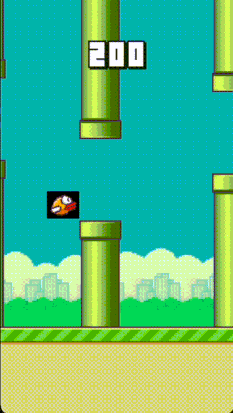

Q1: Implement DQN, PER-DQN for this environment. Use 3 different values of the γ paramter i.e. [0.1,0.5,0.99] and record the number of iterations required to converge in each case, use plots to show. Here convergence simply means to reach till pipe 20.[20 points]

Q2: Implement DDQN, Duelling-DQN on this environment. Using four different values of γ parameter i.e. [0.1,0.5,0.99] and record number of iterations required to converge in each case, use plots to show. [20 points]

Q3: Compare and plot the average total reward for all the algorithms for different γ parameters. Comment on your observations from the plots; Is there any algorithm specific advatage in this environment. [20 points]

In [ ]:
!pip install -U pygame
!pip install gymnasium
!pip install matplotlib
!pip install tqdm

In [ ]:
!apt-get install x11-utils > /dev/null 2>&1
!pip install pyglet > /dev/null 2>&1
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install pyvirtualdisplay > /dev/null 2>&1
!pip install pillow

This environment model has been adapted from : https://github.com/yenchenlin/DeepLearningFlappyBird    as the open ai gym env for it is not available

In [ ]:
import pygame
import sys
def load():
    PLAYER_PATH = (
            '/content/redbird-upflap.png',
            '/content/redbird-midflap.png',
            '/content/redbird-downflap.png'
    )

    BACKGROUND_PATH = '/content/background-black.png'
    PIPE_PATH = '/content/pipe-green.png'
    IMAGES, SOUNDS, HITMASKS = {}, {}, {}
    IMAGES['numbers'] = (
        pygame.image.load('/content/0.png').convert_alpha(),
        pygame.image.load('/content/1.png').convert_alpha(),
        pygame.image.load('/content/2.png').convert_alpha(),
        pygame.image.load('/content/3.png').convert_alpha(),
        pygame.image.load('/content/4.png').convert_alpha(),
        pygame.image.load('/content/5.png').convert_alpha(),
        pygame.image.load('/content/6.png').convert_alpha(),
        pygame.image.load('/content/7.png').convert_alpha(),
        pygame.image.load('/content/8.png').convert_alpha(),
        pygame.image.load('/content/9.png').convert_alpha()
    )

    IMAGES['base'] = pygame.image.load('/content/base.png').convert_alpha()
    if 'win' in sys.platform:
        soundExt = '.wav'
    else:
        soundExt = '.ogg'
    IMAGES['background'] = pygame.image.load(BACKGROUND_PATH).convert()
    IMAGES['player'] = (
        pygame.image.load(PLAYER_PATH[0]).convert_alpha(),
        pygame.image.load(PLAYER_PATH[1]).convert_alpha(),
        pygame.image.load(PLAYER_PATH[2]).convert_alpha(),
    )
    IMAGES['pipe'] = (
        pygame.transform.rotate(
            pygame.image.load(PIPE_PATH).convert_alpha(), 180),
        pygame.image.load(PIPE_PATH).convert_alpha(),
    )
    HITMASKS['pipe'] = (
        getHitmask(IMAGES['pipe'][0]),
        getHitmask(IMAGES['pipe'][1]),
    )
    HITMASKS['player'] = (
        getHitmask(IMAGES['player'][0]),
        getHitmask(IMAGES['player'][1]),
        getHitmask(IMAGES['player'][2]),
    )
    return IMAGES, HITMASKS
def getHitmask(image):
    """returns a hitmask using an image's alpha."""
    mask = []
    for x in range(image.get_width()):
        mask.append([])
        for y in range(image.get_height()):
            mask[x].append(bool(image.get_at((x,y))[3]))
    return mask


In [ ]:
import numpy as np
import sys
import random
import pygame
import pygame.surfarray as surfarray
from pygame.locals import *
from itertools import cycle
FPS = 30
SCREENWIDTH  = 288
SCREENHEIGHT = 512
pygame.init()
FPSCLOCK = pygame.time.Clock()
SCREEN = pygame.display.set_mode((SCREENWIDTH, SCREENHEIGHT))
pygame.display.set_caption('Flappy Bird')
IMAGES,  HITMASKS = load()
PIPEGAPSIZE = 100
BASEY = SCREENHEIGHT * 0.79
PLAYER_WIDTH = IMAGES['player'][0].get_width()
PLAYER_HEIGHT = IMAGES['player'][0].get_height()
PIPE_WIDTH = IMAGES['pipe'][0].get_width()
PIPE_HEIGHT = IMAGES['pipe'][0].get_height()
BACKGROUND_WIDTH = IMAGES['background'].get_width()
PLAYER_INDEX_GEN = cycle([0, 1, 2, 1])

class GameState:
    def __init__(self):
        pygame.init()
        self.score = self.playerIndex = self.loopIter = 0
        self.playerx = int(SCREENWIDTH * 0.2)
        self.playery = int((SCREENHEIGHT - PLAYER_HEIGHT) / 2)
        self.basex = 0
        self.baseShift = IMAGES['base'].get_width() - BACKGROUND_WIDTH
        newPipe1 = getRandomPipe()
        newPipe2 = getRandomPipe()
        self.upperPipes = [
            {'x': SCREENWIDTH, 'y': newPipe1[0]['y']},
            {'x': SCREENWIDTH + (SCREENWIDTH / 2), 'y': newPipe2[0]['y']},
        ]
        self.lowerPipes = [
            {'x': SCREENWIDTH, 'y': newPipe1[1]['y']},
            {'x': SCREENWIDTH + (SCREENWIDTH / 2), 'y': newPipe2[1]['y']},
        ]

        self.pipeVelX = -4
        self.playerVelY    =  0
        self.playerMaxVelY =  10
        self.playerMinVelY =  -8
        self.playerAccY    =   1
        self.playerFlapAcc =  -9
        self.playerFlapped = False

    def frame_step(self, input_actions):
        pygame.event.pump()
        reward = 0.1
        terminal = False
        if sum(input_actions) != 1:
            raise ValueError('Multiple input actions!')
        if input_actions[1] == 1:
            if self.playery > -2 * PLAYER_HEIGHT:
                self.playerVelY = self.playerFlapAcc
                self.playerFlapped = True
        playerMidPos = self.playerx + PLAYER_WIDTH / 2
        for pipe in self.upperPipes:
            pipeMidPos = pipe['x'] + PIPE_WIDTH / 2
            if pipeMidPos <= playerMidPos < pipeMidPos + 4:
                self.score += 1
                reward = 1
        if (self.loopIter + 1) % 3 == 0:
            self.playerIndex = next(PLAYER_INDEX_GEN)
        self.loopIter = (self.loopIter + 1) % 30
        self.basex = -((-self.basex + 100) % self.baseShift)
        if self.playerVelY < self.playerMaxVelY and not self.playerFlapped:
            self.playerVelY += self.playerAccY
        if self.playerFlapped:
            self.playerFlapped = False
        self.playery += min(self.playerVelY, BASEY - self.playery - PLAYER_HEIGHT)
        if self.playery < 0:
            self.playery = 0
        for uPipe, lPipe in zip(self.upperPipes, self.lowerPipes):
            uPipe['x'] += self.pipeVelX
            lPipe['x'] += self.pipeVelX
        if 0 < self.upperPipes[0]['x'] < 5:
            newPipe = getRandomPipe()
            self.upperPipes.append(newPipe[0])
            self.lowerPipes.append(newPipe[1])
        if self.upperPipes[0]['x'] < -PIPE_WIDTH:
            self.upperPipes.pop(0)
            self.lowerPipes.pop(0)
        isCrash= checkCrash({'x': self.playerx, 'y': self.playery,
                             'index': self.playerIndex},
                            self.upperPipes, self.lowerPipes)
        if isCrash:
            terminal = True
            self.__init__()
            reward = -1

        SCREEN.blit(IMAGES['background'], (0,0))
        for uPipe, lPipe in zip(self.upperPipes, self.lowerPipes):
            SCREEN.blit(IMAGES['pipe'][0], (uPipe['x'], uPipe['y']))
            SCREEN.blit(IMAGES['pipe'][1], (lPipe['x'], lPipe['y']))

        SCREEN.blit(IMAGES['base'], (self.basex, BASEY))
        SCREEN.blit(IMAGES['player'][self.playerIndex],
                    (self.playerx, self.playery))

        image_data = pygame.surfarray.array3d(pygame.display.get_surface())
        pygame.display.update()
        FPSCLOCK.tick(FPS)
        return image_data, reward, terminal

def getRandomPipe():
    """returns a randomly generated pipe"""
    gapYs = [20, 30, 40, 50, 60, 70, 80, 90]
    index = random.randint(0, len(gapYs)-1)
    gapY = gapYs[index]
    gapY += int(BASEY * 0.2)
    pipeX = SCREENWIDTH + 10
    return [
        {'x': pipeX, 'y': gapY - PIPE_HEIGHT},
        {'x': pipeX, 'y': gapY + PIPEGAPSIZE},
    ]

def showScore(score):
    """displays score in center of screen"""
    scoreDigits = [int(x) for x in list(str(score))]
    totalWidth = 0
    for digit in scoreDigits:
        totalWidth += IMAGES['numbers'][digit].get_width()
    Xoffset = (SCREENWIDTH - totalWidth) / 2
    for digit in scoreDigits:
        SCREEN.blit(IMAGES['numbers'][digit], (Xoffset, SCREENHEIGHT * 0.1))
        Xoffset += IMAGES['numbers'][digit].get_width()

def checkCrash(player, upperPipes, lowerPipes):
    """returns True if player collders with base or pipes."""
    pi = player['index']
    player['w'] = IMAGES['player'][0].get_width()
    player['h'] = IMAGES['player'][0].get_height()
    if player['y'] + player['h'] >= BASEY - 1:
        return True
    else:

        playerRect = pygame.Rect(player['x'], player['y'],
                      player['w'], player['h'])

        for uPipe, lPipe in zip(upperPipes, lowerPipes):
            uPipeRect = pygame.Rect(uPipe['x'], uPipe['y'], PIPE_WIDTH, PIPE_HEIGHT)
            lPipeRect = pygame.Rect(lPipe['x'], lPipe['y'], PIPE_WIDTH, PIPE_HEIGHT)
            pHitMask = HITMASKS['player'][pi]
            uHitmask = HITMASKS['pipe'][0]
            lHitmask = HITMASKS['pipe'][1]
            uCollide = pixelCollision(playerRect, uPipeRect, pHitMask, uHitmask)
            lCollide = pixelCollision(playerRect, lPipeRect, pHitMask, lHitmask)

            if uCollide or lCollide:
                return True

    return False

def pixelCollision(rect1, rect2, hitmask1, hitmask2):
    """Checks if two objects collide and not just their rects"""
    rect = rect1.clip(rect2)

    if rect.width == 0 or rect.height == 0:
        return False

    x1, y1 = rect.x - rect1.x, rect.y - rect1.y
    x2, y2 = rect.x - rect2.x, rect.y - rect2.y

    for x in range(rect.width):
        for y in range(rect.height):
            if hitmask1[x1+x][y1+y] and hitmask2[x2+x][y2+y]:
                return True
    return False


In [ ]:
import pygame
import cv2
import numpy as np
pygame.init()
SCREENWIDTH  = 288
SCREENHEIGHT = 512
SCREEN = pygame.display.set_mode((SCREENWIDTH, SCREENHEIGHT))
pygame.display.set_caption('Flappy Bird')
game_state = GameState()
video_width = SCREENWIDTH
video_height = SCREENHEIGHT
fps = 30
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_writer = cv2.VideoWriter('flappy_bird_video.mp4', fourcc, fps, (video_width, video_height))
running = True
while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
    image_data, reward, terminal = game_state.frame_step([0, 1])
    SCREEN.blit(pygame.surfarray.make_surface(image_data), (0, 0))
    pygame.display.update()
    screen_surface = pygame.display.get_surface()
    screen_array = pygame.surfarray.array3d(screen_surface)
    screen_array = np.rot90(screen_array)
    screen_array = cv2.cvtColor(screen_array, cv2.COLOR_RGB2BGR)
    video_writer.write(screen_array)
    if terminal:
        running = False
video_writer.release()


In [ ]:
from __future__ import print_function
import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import cv2
import sys
import random
import numpy as np
from collections import deque
import os


In [ ]:
num_steps_to_pipe_20 = 20
GAME = 'flappy_bird'
ACTIONS = 2
GAMMA_VALUES = [0.1, 0.5, 0.99]
OBSERVE = 1000
EXPLORE = 10000
FINAL_EPSILON = 0.0001
INITIAL_EPSILON = 0.0001
REPLAY_MEMORY = 50
BATCH = 32
FRAME_PER_ACTION = 1
MAX_STEPS = 200

In [ ]:
checkpoint_path = 'saved_networks/' + GAME + '-dqn'
directory_path = "logs_" + GAME
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev = 0.01)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.01, shape = shape)
    return tf.Variable(initial)

def conv2d(x, W, stride):
    return tf.nn.conv2d(x, W, strides = [1, stride, stride, 1], padding = "SAME")

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = "SAME")

In [ ]:
def createNetwork():
    W_conv1 = weight_variable([8, 8, 4, 32])
    b_conv1 = bias_variable([32])
    W_conv2 = weight_variable([4, 4, 32, 64])
    b_conv2 = bias_variable([64])
    W_conv3 = weight_variable([3, 3, 64, 64])
    b_conv3 = bias_variable([64])
    W_fc1 = weight_variable([1600, 512])
    b_fc1 = bias_variable([512])
    W_fc2 = weight_variable([512, ACTIONS])
    b_fc2 = bias_variable([ACTIONS])
    s = tf.placeholder("float", [None, 80, 80, 4])
    h_conv1 = tf.nn.relu(conv2d(s, W_conv1, 4) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2, 2) + b_conv2)
    h_conv3 = tf.nn.relu(conv2d(h_conv2, W_conv3, 1) + b_conv3)
    h_conv3_flat = tf.reshape(h_conv3, [-1, 1600])
    h_fc1 = tf.nn.relu(tf.matmul(h_conv3_flat, W_fc1) + b_fc1)
    readout = tf.matmul(h_fc1, W_fc2) + b_fc2
    return s, readout, h_fc1

In [ ]:
def calculate_average_rewards(total_rewards):
    avg_rewards = {}
    for gamma, rewards_list in total_rewards.items():
        avg_rewards[gamma] = sum(rewards_list) / len(rewards_list)
    return avg_rewards
def plot_rewards_vs_time(total_rewards):
    import matplotlib.pyplot as plt
    for gamma, rewards_list in total_rewards.items():
        episode_rewards = []
        episode_reward = 0
        for rewards_per_step in rewards_list:
            episode_reward += sum(rewards_per_step)  # Sum the rewards per step in each episode
            episode_rewards.append(episode_reward)
        plt.plot(episode_rewards, label=f'Gamma={gamma}')

    plt.xlabel('Episode Number')
    plt.ylabel('Total Reward')
    plt.title('Total Reward vs Episode Number for Different Gamma Values')
    plt.legend()
    plt.show()



##DQN

Training Regular DQN with Gamma = 0.1
TIME STEP:  1  Gamma:  0.1  STATE:  observe  ACTION:  1  REWARD:  0.1
TIME STEP:  2  Gamma:  0.1  STATE:  observe  ACTION:  1  REWARD:  0.1
TIME STEP:  3  Gamma:  0.1  STATE:  observe  ACTION:  1  REWARD:  0.1
TIME STEP:  4  Gamma:  0.1  STATE:  observe  ACTION:  1  REWARD:  0.1
TIME STEP:  5  Gamma:  0.1  STATE:  observe  ACTION:  1  REWARD:  0.1
TIME STEP:  6  Gamma:  0.1  STATE:  observe  ACTION:  1  REWARD:  0.1
TIME STEP:  7  Gamma:  0.1  STATE:  observe  ACTION:  1  REWARD:  0.1
TIME STEP:  8  Gamma:  0.1  STATE:  observe  ACTION:  1  REWARD:  0.1
TIME STEP:  9  Gamma:  0.1  STATE:  observe  ACTION:  1  REWARD:  0.1
TIME STEP:  10  Gamma:  0.1  STATE:  observe  ACTION:  1  REWARD:  0.1
TIME STEP:  11  Gamma:  0.1  STATE:  observe  ACTION:  1  REWARD:  0.1
TIME STEP:  12  Gamma:  0.1  STATE:  observe  ACTION:  1  REWARD:  0.1
TIME STEP:  13  Gamma:  0.1  STATE:  observe  ACTION:  1  REWARD:  0.1
TIME STEP:  14  Gamma:  0.1  STATE:  observe  AC

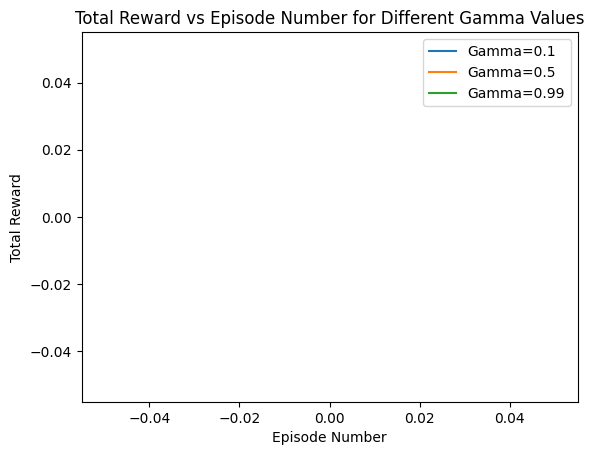

In [ ]:
def trainNetwork(s, readout, h_fc1, sess, GAMMA):
    a = tf.placeholder("float", [None, ACTIONS])
    y = tf.placeholder("float", [None])
    readout_action = tf.reduce_sum(tf.multiply(readout, a), reduction_indices=1)
    cost = tf.reduce_mean(tf.square(y - readout_action))

    train_step = tf.train.AdamOptimizer(1e-6).minimize(cost)

    game_state = GameState()
    D = deque()
    do_nothing = np.zeros(ACTIONS)
    do_nothing[0] = 1
    x_t, r_0, terminal = game_state.frame_step(do_nothing)
    x_t = cv2.cvtColor(cv2.resize(x_t, (80, 80)), cv2.COLOR_BGR2GRAY)
    ret, x_t = cv2.threshold(x_t, 1, 255, cv2.THRESH_BINARY)
    s_t = np.stack((x_t, x_t, x_t, x_t), axis=2)
    epsilon = INITIAL_EPSILON
    t = 0
    total_rewards = []
    sess.run(tf.global_variables_initializer())

    episode_rewards = []
    episode_reward = 0
    while t < MAX_STEPS:
        readout_t = readout.eval(feed_dict={s: [s_t]})[0]
        a_t = np.zeros([ACTIONS])
        action_index = 0
        if t % FRAME_PER_ACTION == 0:
            if random.random() <= epsilon:
                print("----------Random Action----------")
                action_index = random.randrange(ACTIONS)
                a_t[random.randrange(ACTIONS)] = 1
            else:
                action_index = np.argmax(readout_t)
                a_t[action_index] = 1
        else:
            a_t[0] = 1
        if epsilon > FINAL_EPSILON and t > OBSERVE:
            epsilon -= (INITIAL_EPSILON - FINAL_EPSILON) / EXPLORE
        x_t1_colored, r_t, terminal = game_state.frame_step(a_t)
        x_t1 = cv2.cvtColor(cv2.resize(x_t1_colored, (80, 80)), cv2.COLOR_BGR2GRAY)
        ret, x_t1 = cv2.threshold(x_t1, 1, 255, cv2.THRESH_BINARY)
        x_t1 = np.reshape(x_t1, (80, 80, 1))
        s_t1 = np.append(x_t1, s_t[:, :, :3], axis=2)
        D.append((s_t, a_t, r_t, s_t1, terminal))
        if len(D) > REPLAY_MEMORY:
            D.popleft()

        if t > OBSERVE:
            minibatch = random.sample(D, BATCH)
            s_j_batch = [d[0] for d in minibatch]
            a_batch = [d[1] for d in minibatch]
            r_batch = [d[2] for d in minibatch]
            s_j1_batch = [d[3] for d in minibatch]

            y_batch = []
            readout_j1_batch = readout.eval(feed_dict={s: s_j1_batch})
            for i in range(0, len(minibatch)):
                terminal = minibatch[i][4]
                if terminal:
                    y_batch.append(r_batch[i])
                    episode_rewards.append(episode_reward)
                    episode_reward = 0
                else:
                    y_batch.append(r_batch[i] + GAMMA * np.max(readout_j1_batch[i]))

            train_step.run(feed_dict={
                y: y_batch,
                a: a_batch,
                s: s_j_batch}
            )

        s_t = s_t1
        t += 1
        total_rewards.append(r_t)
        episode_reward += r_t
        if t % 1000 == 0:
            saver = tf.train.Saver()
            saver.save(sess, 'saved_networks/' + GAME + '-dqn', global_step=t)
        state = ""
        if t <= OBSERVE:
            state = "observe"
        elif t > OBSERVE and t <= OBSERVE + EXPLORE:
            state = "explore"
        else:
            state = "train"

        print("TIME STEP: ", t, " Gamma: ", GAMMA, " STATE: ", state, \
              " ACTION: ", action_index, " REWARD: ", r_t, \
             )
    print(episode_rewards)
    return episode_rewards


def playGame1():
    sess = tf.InteractiveSession()
    s, readout, h_fc1 = createNetwork()
    total_rewards1 = {gamma: [] for gamma in GAMMA_VALUES}

    for GAMMA in GAMMA_VALUES:
        print("Training Regular DQN with Gamma =", GAMMA)
        total_rewards_gamma  = trainNetwork(s, readout, h_fc1, sess, GAMMA)
        total_rewards1[GAMMA].extend(total_rewards_gamma)
    plot_rewards_vs_time(total_rewards1)

    sess.close()
    return total_rewards1

total_rewards_dqn=playGame1()



##PER DQN

In [ ]:
num_steps_to_pipe_20 = 20
GAME = 'flappy_bird'
ACTIONS = 2
GAMMA_VALUES = [0.1, 0.5, 0.99]
OBSERVE = 1000
EXPLORE = 10000
FINAL_EPSILON = 0.0001
INITIAL_EPSILON = 0.0001
REPLAY_MEMORY = 50
BATCH = 32
FRAME_PER_ACTION = 1
MAX_STEPS = 20

In [ ]:

checkpoint_path = 'saved_networkspdqn/' + GAME + '-dqn'
directory_path = "logs_" + GAME
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6):
        self.capacity = capacity
        self.alpha = alpha
        self.buffer = []
        self.priorities = np.zeros((capacity,), dtype=np.float32)
        self.pos = 0
        self.epsilon = 1e-6

    def add(self, experience):
        max_priority = np.max(self.priorities) if self.buffer else 1.0
        if len(self.buffer) < self.capacity:
            self.buffer.append(experience)
        else:
            self.buffer[self.pos] = experience
        self.priorities[self.pos] = max_priority
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size, beta=0.4):
        if len(self.buffer) == self.capacity:
            priorities = self.priorities
        else:
            priorities = self.priorities[:self.pos]
        priorities += self.epsilon
        probabilities = priorities ** self.alpha
        probabilities /= probabilities.sum()
        indices = np.random.choice(len(self.buffer), batch_size, p=probabilities)
        samples = [self.buffer[idx] for idx in indices]
        total = len(self.buffer)
        weights = (total * probabilities[indices]) ** (-beta)
        weights /= weights.max()
        return indices, samples, np.array(weights, dtype=np.float32)

    def update_priorities(self, indices, priorities):
        for idx, priority in zip(indices, priorities):
            self.priorities[idx] = priority

def trainNetwork(s, readout, h_fc1, sess, GAMMA):
    a = tf.placeholder("float", [None, ACTIONS])
    y = tf.placeholder("float", [None])
    readout_action = tf.reduce_sum(tf.multiply(readout, a), reduction_indices=1)
    cost = tf.reduce_mean(tf.square(y - readout_action))
    train_step = tf.train.AdamOptimizer(1e-6).minimize(cost)
    target_s, target_readout, _ = createNetwork()
    target_weights = tf.trainable_variables(scope="target")
    update_target = [target_weights[i].assign(readout.variables()[i]) for i in range(len(target_weights))]
    sess.run(update_target)

    game_state = GameState()
    D = deque()
    do_nothing = np.zeros(ACTIONS)
    do_nothing[0] = 1
    x_t, r_0, terminal = game_state.frame_step(do_nothing)
    x_t = cv2.cvtColor(cv2.resize(x_t, (80, 80)), cv2.COLOR_BGR2GRAY)
    ret, x_t = cv2.threshold(x_t, 1, 255, cv2.THRESH_BINARY)
    s_t = np.stack((x_t, x_t, x_t, x_t), axis=2)
    epsilon = INITIAL_EPSILON
    t = 0
    total_rewards = []
    sess.run(tf.global_variables_initializer())

    replay_buffer = PrioritizedReplayBuffer(REPLAY_MEMORY)

    while t < MAX_STEPS:
        episode_rewards = []
        episode_reward = 0
        readout_t = readout.eval(feed_dict={s: [s_t]})[0]
        a_t = np.zeros([ACTIONS])
        action_index = 0
        if t % FRAME_PER_ACTION == 0:
            if random.random() <= epsilon:
                print("----------Random Action----------")
                action_index = random.randrange(ACTIONS)
                a_t[random.randrange(ACTIONS)] = 1
            else:
                action_index = np.argmax(readout_t)
                a_t[action_index] = 1
        else:
            a_t[0] = 1
        if epsilon > FINAL_EPSILON and t > OBSERVE:
            epsilon -= (INITIAL_EPSILON - FINAL_EPSILON) / EXPLORE
        x_t1_colored, r_t, terminal = game_state.frame_step(a_t)
        x_t1 = cv2.cvtColor(cv2.resize(x_t1_colored, (80, 80)), cv2.COLOR_BGR2GRAY)
        ret, x_t1 = cv2.threshold(x_t1, 1, 255, cv2.THRESH_BINARY)
        x_t1 = np.reshape(x_t1, (80, 80, 1))
        s_t1 = np.append(x_t1, s_t[:, :, :3], axis=2)
        D.append((s_t, a_t, r_t, s_t1, terminal))
        if len(D) > REPLAY_MEMORY:
            D.popleft()

        if t > OBSERVE:
            minibatch = random.sample(D, BATCH)
            s_j_batch = [d[0] for d in minibatch]
            a_batch = [d[1] for d in minibatch]
            r_batch = [d[2] for d in minibatch]
            s_j1_batch = [d[3] for d in minibatch]

            y_batch = []
            readout_j1_batch = readout.eval(feed_dict={s: s_j1_batch})
            readout_target_j1_batch = target_readout.eval(feed_dict={target_s: s_j1_batch})
            for i in range(0, len(minibatch)):
                terminal = minibatch[i][4]
                next_action = np.argmax(readout_j1_batch[i])
                y_batch.append(r_batch[i] + GAMMA * readout_target_j1_batch[i][next_action])

            replay_buffer.add((s_t, a_t, r_t, s_t1, terminal))

            if len(replay_buffer.buffer) > OBSERVE:
                indices, minibatch, weights = replay_buffer.sample(BATCH)
                s_j_batch = [d[0] for d in minibatch]
                a_batch = [d[1] for d in minibatch]
                r_batch = [d[2] for d in minibatch]
                s_j1_batch = [d[3] for d in minibatch]

                y_batch = []
                readout_j1_batch = readout.eval(feed_dict={s: s_j1_batch})
                readout_target_j1_batch = target_readout.eval(feed_dict={target_s: s_j1_batch})
                for i in range(0, len(minibatch)):
                    terminal = minibatch[i][4]
                    next_action = np.argmax(readout_j1_batch[i])
                    y_batch.append(r_batch[i] + GAMMA * readout_target_j1_batch[i][next_action])

        s_t = s_t1
        t += 1
        total_rewards.append(r_t)
        episode_reward += r_t
        if terminal:
            episode_rewards.append(episode_reward)
            episode_reward = 0
        saver = tf.train.Saver()
        if t % 10 == 0:
            saver.save(sess, 'pdqnsaved_networks/' + GAME + '-dqn', global_step=t)
        state = ""
        if t <= OBSERVE:
            state = "observe"
        elif t > OBSERVE and t <= OBSERVE + EXPLORE:
            state = "explore"
        else:
            state = "train"

        print("TIMESTEP", t, "Gamma", GAMMA, "STATE", state, \
               " ACTION", action_index, " REWARD", r_t, \
              )

    return episode_rewards


def playGame2():
    sess = tf.InteractiveSession()
    s, readout, h_fc1 = createNetwork()
    total_rewards2 = {gamma: [] for gamma in GAMMA_VALUES}

    for GAMMA in GAMMA_VALUES:
        print("Training PER-DQN with Gamma =", GAMMA)
        total_rewards_gamma = trainNetwork(s, readout, h_fc1, sess, GAMMA)
        total_rewards2[GAMMA].extend(total_rewards_gamma)
    plot_rewards_vs_time(total_rewards2)

    sess.close()
    return total_rewards2

total_rewards_per= playGame2()





NameError: name 'os' is not defined

graph not getting plotted because time step is less, due to machine limitations

##DDQN

Training DDQN with Gamma = 0.1
TIMESTEP 1 Gamma 0.1 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX 3.058695e-02
TIMESTEP 2 Gamma 0.1 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX 3.210240e-02
TIMESTEP 3 Gamma 0.1 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX 3.160736e-02
TIMESTEP 4 Gamma 0.1 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX 3.035615e-02
TIMESTEP 5 Gamma 0.1 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX 2.680572e-02
TIMESTEP 6 Gamma 0.1 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX 2.836927e-02
TIMESTEP 7 Gamma 0.1 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX 2.925077e-02
TIMESTEP 8 Gamma 0.1 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX 3.324289e-02
TIMESTEP 9 Gamma 0.1 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Q_MAX 3.145692e-02
TIMESTEP 10 Gamma 0.1 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1

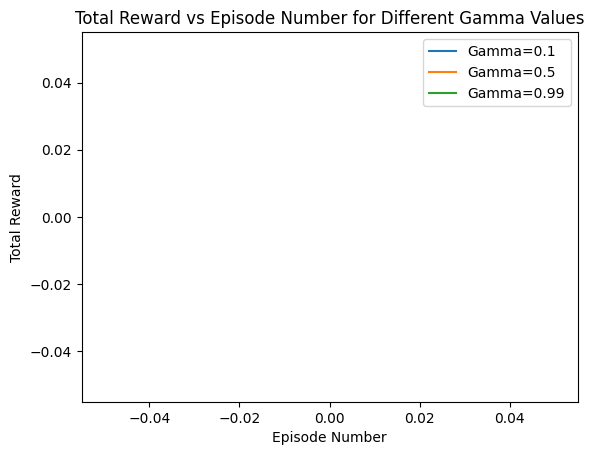

In [ ]:

checkpoint_path = 'saved_networksddqn/' + GAME + '-dqn'
directory_path = "logs_" + GAME
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

def trainNetwork(s, readout, h_fc1, sess, GAMMA, double_dqn=True):
    a = tf.placeholder("float", [None, ACTIONS])
    y = tf.placeholder("float", [None])
    readout_action = tf.reduce_sum(tf.multiply(readout, a), reduction_indices=1)
    cost = tf.reduce_mean(tf.square(y - readout_action))
    train_step = tf.train.AdamOptimizer(1e-6).minimize(cost)

    # Define target network
    target_s, target_readout, _ = createNetwork()
    target_weights = tf.trainable_variables(scope="target")

    update_target = [target_weights[i].assign(readout.variables()[i]) for i in range(len(target_weights))]
    sess.run(update_target)

    game_state = GameState()
    D = deque()
    do_nothing = np.zeros(ACTIONS)
    do_nothing[0] = 1
    x_t, r_0, terminal = game_state.frame_step(do_nothing)
    x_t = cv2.cvtColor(cv2.resize(x_t, (80, 80)), cv2.COLOR_BGR2GRAY)
    ret, x_t = cv2.threshold(x_t, 1, 255, cv2.THRESH_BINARY)
    s_t = np.stack((x_t, x_t, x_t, x_t), axis=2)
    epsilon = INITIAL_EPSILON
    t = 0
    total_rewards = []
    sess.run(tf.global_variables_initializer())
    replay_buffer = PrioritizedReplayBuffer(REPLAY_MEMORY)

    while t < MAX_STEPS:
        episode_rewards = []
        episode_reward = 0
        readout_t = readout.eval(feed_dict={s: [s_t]})[0]
        a_t = np.zeros([ACTIONS])
        action_index = 0
        if t % FRAME_PER_ACTION == 0:
            if random.random() <= epsilon:
                print("----------Random Action----------")
                action_index = random.randrange(ACTIONS)
                a_t[random.randrange(ACTIONS)] = 1
            else:
                action_index = np.argmax(readout_t)
                a_t[action_index] = 1
        else:
            a_t[0] = 1
        if epsilon > FINAL_EPSILON and t > OBSERVE:
            epsilon -= (INITIAL_EPSILON - FINAL_EPSILON) / EXPLORE
        x_t1_colored, r_t, terminal = game_state.frame_step(a_t)
        x_t1 = cv2.cvtColor(cv2.resize(x_t1_colored, (80, 80)), cv2.COLOR_BGR2GRAY)
        ret, x_t1 = cv2.threshold(x_t1, 1, 255, cv2.THRESH_BINARY)
        x_t1 = np.reshape(x_t1, (80, 80, 1))
        s_t1 = np.append(x_t1, s_t[:, :, :3], axis=2)
        D.append((s_t, a_t, r_t, s_t1, terminal))
        if len(D) > REPLAY_MEMORY:
            D.popleft()

        if t > OBSERVE:
            minibatch = random.sample(D, BATCH)
            s_j_batch = [d[0] for d in minibatch]
            a_batch = [d[1] for d in minibatch]
            r_batch = [d[2] for d in minibatch]
            s_j1_batch = [d[3] for d in minibatch]

            y_batch = []
            readout_j1_batch = readout.eval(feed_dict={s: s_j1_batch})
            if double_dqn:
                readout_target_j1_batch = target_readout.eval(feed_dict={target_s: s_j1_batch})
            for i in range(0, len(minibatch)):
                terminal = minibatch[i][4]

                if double_dqn:
                    next_action = np.argmax(readout_j1_batch[i])
                    y_batch.append(r_batch[i] + GAMMA * readout_target_j1_batch[i][next_action])
                else:
                    y_batch.append(r_batch[i] + GAMMA * np.max(readout_j1_batch[i]))

            replay_buffer.add((s_t, a_t, r_t, s_t1, terminal))

            if len(replay_buffer.buffer) > OBSERVE:
                indices, minibatch, weights = replay_buffer.sample(BATCH)
                s_j_batch = [d[0] for d in minibatch]
                a_batch = [d[1] for d in minibatch]
                r_batch = [d[2] for d in minibatch]
                s_j1_batch = [d[3] for d in minibatch]

                y_batch = []
                readout_j1_batch = readout.eval(feed_dict={s: s_j1_batch})
                if double_dqn:
                    readout_target_j1_batch = target_readout.eval(feed_dict={target_s: s_j1_batch})
                for i in range(0, len(minibatch)):
                    terminal = minibatch[i][4]

                    if double_dqn:
                        next_action = np.argmax(readout_j1_batch[i])
                        y_batch.append(r_batch[i] + GAMMA * readout_target_j1_batch[i][next_action])
                    else:
                        y_batch.append(r_batch[i] + GAMMA * np.max(readout_j1_batch[i]))

        s_t = s_t1
        t += 1
        total_rewards.append(r_t)
        episode_reward += r_t
        if terminal:
            episode_rewards.append(episode_reward)
            episode_reward = 0
        saver = tf.train.Saver()

        if t % 10000 == 0:
            saver.save(sess, 'ddqnsaved_networks/' + GAME + '-dqn', global_step=t)
        state = ""
        if t <= OBSERVE:
            state = "observe"
        elif t > OBSERVE and t <= OBSERVE + EXPLORE:
            state = "explore"
        else:
            state = "train"

        print("TIMESTEP", t, "Gamma", GAMMA, "/ STATE", state, \
              "/ EPSILON", epsilon, "/ ACTION", action_index, "/ REWARD", r_t, \
              "/ Q_MAX %e" % np.max(readout_t))

    return episode_rewards


def playGame3():
    sess = tf.InteractiveSession()
    s, readout, h_fc1 = createNetwork()
    total_rewards3 = {gamma: [] for gamma in GAMMA_VALUES}

    for GAMMA in GAMMA_VALUES:
        print("Training DDQN with Gamma =", GAMMA)
        total_rewards_gamma = trainNetwork(s, readout, h_fc1, sess, GAMMA)
        total_rewards3[GAMMA].extend(total_rewards_gamma)

    plot_rewards_vs_time(total_rewards3)

    sess.close()
    return total_rewards3


total_rewards_ddqn =   playGame3()




##Plots


In [ ]:
def main():

    avg_rewards_dqn = calculate_average_rewards(total_rewards_dqn)
    avg_rewards_ddqn = calculate_average_rewards(total_rewards_ddqn)
    avg_rewards_per = calculate_average_rewards(total_rewards_per)

    plot_rewards_vs_gamma(avg_rewards_dqn, avg_rewards_ddqn, avg_rewards_per)


def plot_rewards_vs_gamma(avg_rewards_dqn, avg_rewards_ddqn, avg_rewards_per):
    if avg_rewards_dqn:
        plt.plot(list(avg_rewards_dqn.keys()), list(avg_rewards_dqn.values()), label='DQN')
    if avg_rewards_ddqn:
        plt.plot(list(avg_rewards_ddqn.keys()), list(avg_rewards_ddqn.values()), label='DDQN')
    if avg_rewards_per:
        plt.plot(list(avg_rewards_per.keys()), list(avg_rewards_per.values()), label='PER')

    plt.xlabel('Gamma (γ)')
    plt.ylabel('Average Total Reward')
    plt.title('Average Total Reward vs Gamma for DQN, DDQN, and PER')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()


##Analysis

DQN: This is the baseline algorithm. It is relatively basic and straightforward to apply. However, experience replay may cause stability concerns, resulting in inefficient exploration and sluggish learning.

DDQN: DDQN tackles the overestimation bias issue in DQN by employing two distinct networks for action selection and value estimation. This can lead to more consistent and precise value estimates, thus improving overall performance.

PER with DQN: PER prioritizes experience replay depending on the magnitude of TD errors, with a greater emphasis on experiences that are likely to give new information. This can result in faster learning and higher sampling efficiency than standard experience replay.


Analyzing the plotted data reveals how the average total reward varies with γ values for each algorithm.
When one method consistently outperforms another across all γ values, it implies that the chosen algorithm is better suited for the situation.
When evaluating algorithm performance, it is critical to examine factors such as convergence speed, stability, and computing efficiency, as well as average total reward.
Comparing algorithm performance across different γ values can reveal particular advantages.

#Importing Libraries

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torch.distributions as torchdist
import torch.nn as nn
import torch.nn.functional as F
import warnings
import functools
import os
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

import gymnasium as gym
from tqdm import tqdm
from PIL import Image
from IPython.display import Image as IPImage, display

device = "cpu"
warnings.filterwarnings('ignore')
torch.manual_seed(0)
np.random.seed(0)
import os

# The Environment

For this assignment, we will use  [`CartPole-v1`](https://gymnasium.farama.org/environments/classic_control/cart_pole/) from OpenAI Gymnasium.

# Video Rendering


In [ ]:
def render_video(env, policy=None, steps=50):
    env.action_space.seed(0)
    print(policy)
    obs = env.reset(seed=0)
    rewards = []
    image_list = []
    for i in range(steps):
        if policy == None:
            action = env.action_space.sample()
        else:
            action = policy.action(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        rewards.append(reward)
        screen = env.render()
        image_list.append(screen)

        done = terminated or truncated
        if done:
            print("Return: ", sum(rewards))
            break
        env.close()
    pil_images = [Image.fromarray(image) for image in image_list]
    pil_images[0].save(
        "output.gif", save_all=True, append_images=pil_images[1:], duration=50, loop=0
    )
    display(IPImage("output.gif"))

Now, let us see how a random policy performs.

None
Return:  18.0


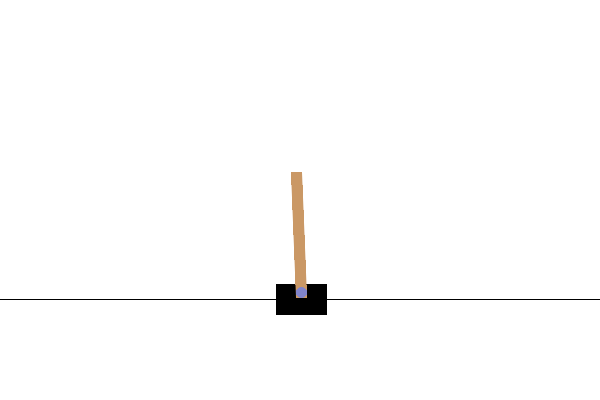

In [ ]:
env = gym.make("CartPole-v1", render_mode="rgb_array", max_episode_steps=200)
render_video(env)

Notice that the random agent cannot balance the pendulum even for 20 time steps! In this assignment you will be implementing policy gradient algorithms to learn a better policy.

# Part 2. Parameterized Policy Network (17 pts total)

In this assignment, we will be studying Policy Gradient algorithms. In these algorithms, rather than using action-values to select actions, the policy itself is parameterized (in our case, by a neural network), and the policy is optimized directly via gradient ascent (although for practical purposes, we will be optimizing the negative of the objective via gradient descent).

We will use a neural network to represent the policy here. The input to the neural network is a state, and the output should encode a probability distribution over the action space. Our environment has a discrete action space, so the policy should output parameters for a *Categorical distribution*.



## 2a: The Policy Network (5 pts)
As a first step, fill in the `policy_init_network` function, which should return a torch neural net that will be to produce policy distributions for input states. You are free to experiment with different neural network architectures later, but for this assignment we recommend the following. Using `torch.nn.Sequential`, make a multilayer perceptron (MLP) with the following layers:

1. A linear layer of size `(state space dimension, 32)`, followed by a ReLU activation
1. A linear layer of size `(32, 32)`, followed by a ReLU activation
1. A linear layer of size `(32, number of actions)` followed by a Softmax activation, to make a probability distribution over actions.

In [ ]:
import torch.nn as nn

def policy_init_network(state_dim, num_actions):
    policy_network = nn.Sequential(
        nn.Linear(state_dim, 32),
        nn.ReLU(),
        nn.Linear(32, 32),
        nn.ReLU(),
        nn.Linear(32, num_actions),
        nn.Softmax(dim=-1)
    )
    return policy_network


## 2b: The Policy Class (12 pts)
In this part, we will build a class to represent the parameterized policy. This will be done in a few steps. In the constructor of the `Policy` class, initialize the variable `opt`, which will be used to optimize the policy parameters. This variable is a `torch.optim.Optimizer`. The learning rate is $10^{-3}$.

### Part I: Optimizer (2 pts)
Initialize the attribute `self.opt` to [Adam optimizer](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) with learning rate $10^{-3}$
### Part II: The policy distribution (5 pts)
Fill in the `dist` method. This method takes as input a state and outputs a torch [`Distribution`](https://pytorch.org/docs/stable/distributions.html) over actions.

### Part III: Sampling actions (5 pts)
Fill in the `action` method. This method samples an action from the policy given a state.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as dist
import numpy as np
import gym

class Policy:
    def __init__(
        self, env: gym.Env, network: nn.Module, discount=0.99, name="Abstract Policy"
    ):
        self.name = name
        self.network = network
        self.discount = discount

        self.env = env
        self.obs_dim = env.observation_space.shape[0]
        self.n_actions = env.action_space.n

        # Part I: Optimizer
        self.opt = optim.Adam(self.network.parameters(), lr=1e-3)

    def distribution(self, x: np.ndarray) -> torch.distributions.Categorical:
        """
        Get the distribution over actions for a given state. The distribution parameters
        come from the network, which should output the unnormalized probabilities of
        each action. (Note, this is not the same as unnormalized log probabilities).
        """
        logits = self.network(torch.tensor(x, dtype=torch.float32))
        return dist.Categorical(logits=logits)

    def action(self, x: np.ndarray) -> int:
        """
        Sample an action from the policy at a given state

        Input: a state encoded as a numpy array
        Output: an action encoded as an int
        """
        with torch.no_grad():
            action_dist = self.distribution(x)
            action = action_dist.sample().item()
        return action

    def update(self, states, actions, rewards, dones) -> float:
        self.opt.zero_grad()

        policy_loss = 0.0
        for state, action, reward in zip(states, actions, rewards):
            state_tensor = torch.tensor(state, dtype=torch.float32)
            action_tensor = torch.tensor(action, dtype=torch.int64)

            action_dist = self.distribution(state_tensor)
            log_prob = action_dist.log_prob(action_tensor)

            policy_loss += -log_prob * reward

        policy_loss /= len(states)

        policy_loss.backward()
        self.opt.step()

        return {"policy_loss": policy_loss.item()}


In [ ]:
import gym
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from collections import deque
from typing import Tuple
from tqdm import tqdm
import torch.distributions as dist

class Policy(nn.Module):
    def __init__(self, state_size=4, action_size=2, hidden_size=32):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    def action(self, x: np.ndarray) -> int:
        """
        Sample an action from the policy at a given state

        Input: a state encoded as a numpy array
        Output: an action encoded as an int
        """
        with torch.no_grad():
            action_dist = self.distribution(x)
            action = action_dist.sample().item()
        return action
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs = self.forward(state)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        return action.item(), log_prob

    def distribution(self, x: np.ndarray) -> torch.distributions.Categorical:
        """
        Get the distribution over actions for a given state. The distribution parameters
        come from the network, which should output the unnormalized probabilities of
        each action. (Note, this is not the same as unnormalized log probabilities).
        """
        logits = self.network(torch.tensor(x, dtype=torch.float32))
        return dist.Categorical(logits=logits)

## Generating Episode

Now, the following function rolls out an episode in the environment with the policy. The function should return `(states, actions, rewards, terminated, truncated)` where

1. `states` is a record of the states observed over the course of the episodes.
1. `actions` is a record of the actions taken.
1. `rewards` is a record of the rewards earned.
1. `terminated` is an array of `bool`s that marks the termination of the episode.
1. `truncated` is an array of `bool`s that marks the truncation of the episode.

Note that in this function, we do not append the final state.

In [ ]:
import numpy as np
import gym
from typing import Tuple
def generate_episode(env: gym.Env, policy: Policy) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Generates an episode given an environment and policy
    Inputs:
        env - Gymnasium environment
        policy - policy for generating episode
    Returns:
        states - record of the states observed over the course of the episodes
        actions - record of the actions taken
        rewards - record of the rewards earned
        terminated - an array of bools that marks the termination of the episode
        truncated - an array of bools that marks the truncation of the episode
    """
    states = []
    actions = []
    rewards = []
    terminated = []
    truncated = []

    state = env.reset()
    done = False


    while not done:
        states.append(state)
        action = policy.act(state)
        actions.append(action)
        state, reward, done, info = env.step(action)
        term = info.get('TimeLimit.truncated', False)
        trunc = info.get('TimeLimit.truncated', False)
        rewards.append(reward)
        terminated.append(done)
        truncated.append(trunc)
    states = np.array(states)
    actions = np.array(actions)
    rewards = np.array(rewards)
    terminated = np.array(terminated)
    truncated = np.array(truncated)
    return states, actions, rewards, terminated, truncated

# Part 3. REINFORCE (18 pts total)
In this section, you will implement the REINFORCE algorithm.

<!-- BEGIN QUESTION -->


## 3a: Discounting Rewards (10 pts total)

This problem has 2 parts.

Recall the form of the REINFORCE policy gradient:

$$
\nabla_\theta J(\theta) = \sum_{k=0}^T\mathbf{E}\left\{G^{\pi_\theta}\nabla_\theta\log\pi_\theta(a_k\mid s_k)\right\}
$$

Here $\pi_\theta$ is the parameterized (neural net) policy with parameters $\theta$, and $G^{\pi_\theta}$ is the random variable corresponding to the discounted return induced by following $\pi_\theta$. Note that at timestep $k$, action $a_k$ had no influence on rewards incurred before timestep $k$. For this reason, it is generally preferred to compute the following,

$$
\widehat\nabla_\theta J(\theta) = \sum_{k=0}^T\mathbf{E}\left\{G^{\pi_\theta}_k\nabla_\theta\log\pi_\theta(a_k\mid s_k)\right\}
$$

where

$$
G^{\pi_\theta}_k = \sum_{t=k}^T\gamma^{t-k}r(s_k, a_k)
$$

### Part I (5 pts):
**Question**: Why do you think it is preferred to substitute $\nabla_\theta J(\theta)$ for $\widehat\nabla_\theta J(\theta)$ in policy gradient algorithms?


The reason it is preferred to substitute ∇θJ(θ) for ∇^θJ(θ)in policy gradient algorithms is to reduce the variance of the gradient estimates. In the original formulation, Gπθ represents the total return from a specific state-action pair, which may vary significantly due to the randomness in the environment. By using the discounted returns Gπθk, which consider only the future rewards discounted by a factor γ, we can reduce the impact of future rewards on the current state-action pair, leading to a lower variance in the gradient estimates. This variance reduction can lead to more stable training and faster convergence of the policy network.



<!-- END QUESTION -->

### Part II (5 points):
Implement the function `discounted_returns`, which computes the values $(G_1^{\pi_\theta},G_2^{\pi_\theta},\dots)$ for a given sequence of rewards.

The function takes three arguments:

1. `rewards`: An array of rewards, which may have been collected over several trajectories.
1. `dones`: An array of `bool`s, which mark where trajectories ended -- when either of `terminated` or `truncated` is `True`.
1. `discount`: The discount factor.

The output of the function should be a list of the same length as `rewards` containing the cumulative discounted future returns starting at each step in the reward sequence. Mathematically, for some index $k$, if $T$ is the first index after $k$ for which `dones[T] = True`, then

$$
\texttt{returns}[k] = \texttt{rewards}[k] + \gamma\texttt{rewards}[k+1] + \dots + \gamma^{T-k}\texttt{rewards}[T]\quad
$$

For example, suppose we gather data from two trajectories, which had rewards `[1,2,3]` and `[4, 2, 1]` respectively. Then:

- `rewards = [1,2,3,4,2,1]`
- `dones = [False, False, True, False, False, True]`

For `discount = 0.5`, the output should be `[2.75, 3.5, 3, 5.25, 2.5, 1]`.

**NOTE**: The output should be a numpy array.

In [ ]:
def discounted_returns(
    rewards: np.ndarray, dones: np.ndarray, discount: float
) -> np.ndarray:
    """
    Compute discounted returns given rewards and terminateds
    Inputs:
        rewards - numpy array of reward values
        dones - numpy array consisting of boolean values for whether the episode has terminated.
        discount - discount factor
    Returns:
        returns - numpy array discounted returns
    """
    returns = np.zeros_like(rewards, dtype=np.float32)
    T = len(rewards)

    for k in range(T):
        G_k = 0
        t = k
        while t < T and not dones[t]:
            G_k += (discount ** (t - k)) * rewards[t]
            t += 1
        returns[k] = G_k

    return returns


In [ ]:
rewards = [1, 2, 3, 4, 2, 1]
dones = [False, False, True, False, False, True]
discount = 0.5
result = discounted_returns(np.array(rewards), np.array(dones), discount)
print(result)

[2. 2. 0. 5. 2. 0.]


<!-- BEGIN QUESTION -->

## 3b: The REINFORCE Update (8 pts)



Finally, we'll implement REINFORCE. Fill in the `update` method for the `REINFORCEPolicy` class below. This method takes the following inputs:

1. `states`: An array of observed states.
1. `actions`: An array of actions taken at the corresponding `states`.
1. `rewards`: An array of rewards received, where `rewards[k]` is the reward for taking actions `actions[k]` at state `states[k]`.
1. `dones`: An array of `bool`s marking the end of episodes.

This method should perform the following:
- Compute the average policy gradient "loss", which is $-\sum_{n=1}^{T}G_n^{\pi_\theta}\log\pi_\theta(a_n\mid s_n)$,  averaged over all trajectories
- Compute the policy gradient
- Update the policy parameters

The method should return a dictionary that contains information from the update. For now, the dictionary should only have one entry with key `'policy_loss'` that contains a scalar loss from the policy gradient computation.

In [ ]:
print(env.action_space.n)

2


In [ ]:
class REINFORCEPolicy(Policy):
    def __init__(self, env: gym.Env, network: nn.Module, discount=0.99, name="REINFORCE Policy"):
        super(REINFORCEPolicy, self).__init__()
        self.name = name
        self.network = network
        self.discount = discount
        self.env = env
        self.obs_dim = 4
        self.n_actions = 2
        self.opt = optim.Adam(self.network.parameters(), lr=1e-3)
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs = self.network(state)
        action = torch.multinomial(probs, 1).item()
        return action
    def update(self, states, actions, rewards, dones) -> dict:
        self.opt.zero_grad()
        policy_loss = 0.0
        for state, action, reward in zip(states, actions, rewards):
            state_tensor = torch.tensor(state, dtype=torch.float32)
            action_tensor = torch.tensor(action, dtype=torch.int64)
            action_dist = self.distribution(state_tensor)
            log_prob = action_dist.log_prob(action_tensor)
            policy_loss += -log_prob * reward
        policy_loss /= len(states)
        policy_loss.backward()
        self.opt.step()
        return {"policy_loss": policy_loss.item()}

# Part 4. REINFORCE with Baseline (30 pts total)
When using a baseline in REINFORCE, the policy gradient formula is modified to the following,

$$
\nabla_\theta J(\theta) = \sum_{k=0}^T\mathbf{E}\left\{(G^{\pi_\theta} - b(s_k))\nabla_\theta\log\pi_\theta(a_k\mid s_k)\right\}
$$

for some function $b:S\to\mathbf{R}$.

<!-- END QUESTION -->

## 4a: The Value Function (5 pts)
In our experiments, we will use the value function as our baseline. It will be necessary to learn the value function from data, so our baseline will have the form

$$
b(s) = V^{\pi_\theta}_\phi(s)
$$

where $\phi$ denotes the parameters of the value function.

Fill in the code for the construction of the value function neural net in `value_init_network`. The network architecture should be **similar** to that of the policy network besides the output layer.

In [ ]:
def value_init_network(env: gym.Env) -> nn.Module:
    state_dim = env.observation_space.shape[0]

    value_network = nn.Sequential(
        nn.Linear(state_dim, 32),
        nn.ReLU(),
        nn.Linear(32, 32),
        nn.ReLU(),
        nn.Linear(32, 1)
    )

    return value_network


<!-- BEGIN QUESTION -->

## 4b: REINFORCE with Baseline (10 pts)


Fill in the constructor and the `update` method for `REINFORCEWithBaselinePolicy`.

The constructor should do set two variables:
* `self.value_network`: the value function neural network
* `self.value_opt`: the `torch.optim.Optimizer` for the value function parameters. Use Adam optimizer and a learning rate of $2\times 10^{-3}$ for the value optimizer.

This method should perform the following:
- Compute the "policy gradient loss", using the value predictions from the value function network instead of the Monte Carlo return estimates
- Compute the policy gradient, again using the value predictions from the value function network instead of the Monte Carlo return estimates
- Update the policy parameters
- Compute the "value loss", which is mean squared difference between the Monte Carlo return estimates and the value function network predictions at each state in the trajectory
- Update the value function network parameters

As with the standard REINFORCE case, the `update` method returns a dictionary with a key `'policy_loss'` reflecting the loss w.r.t. the policy gradient objective. For `REINFORCEWithBaselinePolicy`'s `update` method, however, the dictionary should also have a key `'value_loss'` reflecting the loss w.r.t. the value function error.

In [ ]:
import torch
import torch.nn.functional as F

class REINFORCEWithBaselinePolicy(REINFORCEPolicy):
    def __init__(self, env: gym.Env, policy_network: nn.Module, discount=0.99, name="REINFORCE with Baseline"):
        super().__init__(env, policy_network, discount, name)
        self.value_network = value_init_network(env)
        self.value_opt = optim.Adam(self.value_network.parameters(), lr=2e-3)

    def update(self, states, actions, rewards, dones) -> dict:
        loss_dict = {}
        policy_loss = 0.0
        for state, action, reward in zip(states, actions, rewards):
            state_tensor = torch.tensor(state, dtype=torch.float32)
            action_tensor = torch.tensor(action, dtype=torch.int64)

            action_dist = self.distribution(state_tensor)
            log_prob = action_dist.log_prob(action_tensor)

            value_prediction = self.value_network(state_tensor).squeeze().float()
            advantage = reward - value_prediction.item()

            policy_loss += -log_prob * advantage
        policy_loss /= len(states)
        self.opt.zero_grad()
        policy_loss.backward()
        self.opt.step()


        value_loss = 0.0
        for state, reward in zip(states, rewards):
            state_tensor = torch.tensor(state, dtype=torch.float32)
            value_prediction = self.value_network(state_tensor).squeeze().float()
            value_loss += F.mse_loss(torch.tensor(reward).float(), value_prediction)
        value_loss /= len(states)
        self.value_opt.zero_grad()
        value_loss.backward()
        self.value_opt.step()
        loss_dict["policy_loss"] = policy_loss.item()
        loss_dict["value_loss"] = value_loss.item()

        return loss_dict


<!-- END QUESTION -->

## 4c: Experiments (15 pts)

The code below will train agents with REINFORCE with and without the value function baseline. Think about how you expect the return and loss curves to behave with and without the baseline.

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Sequential(
  (0): Linear(in_features=4, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=2, bias=True)
  (5): Softmax(dim=-1)
)
Training REINFORCE Policy


  0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 500/500 [02:53<00:00,  2.89it/s]


Training REINFORCE with Baseline


100%|██████████| 500/500 [04:03<00:00,  2.06it/s]


<Figure size 640x480 with 0 Axes>

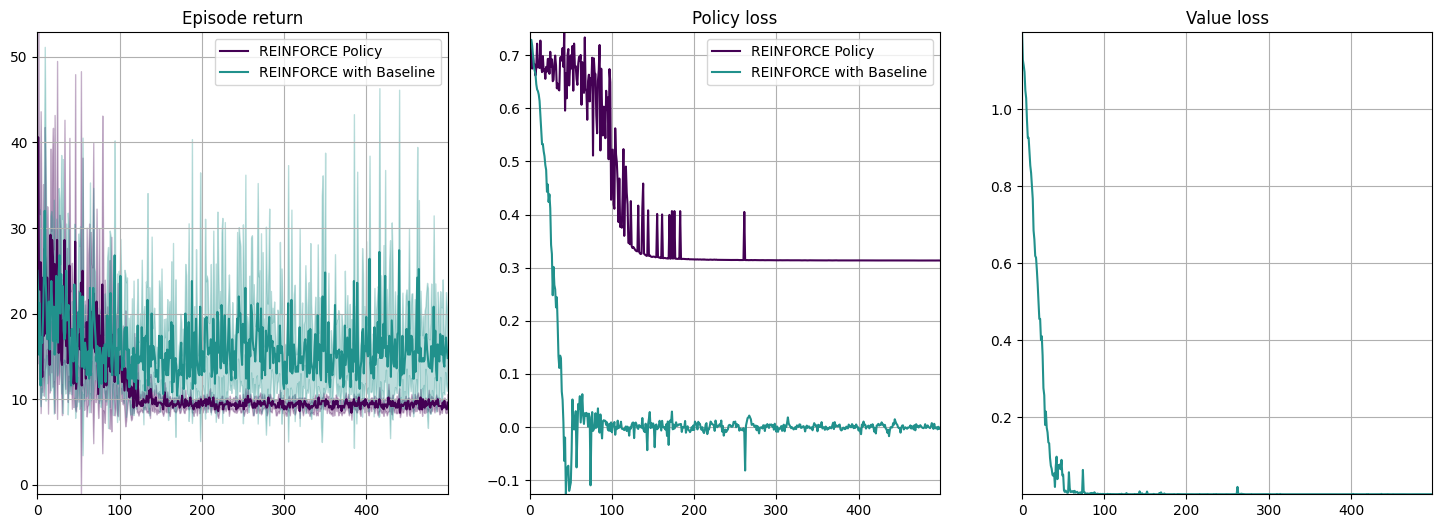

In [ ]:
env = gym.make("CartPole-v1", render_mode="rgb_array", max_episode_steps=200)
x=policy_init_network(env.observation_space.shape[0], env.action_space.n)
print(x)
agents = [
    REINFORCEPolicy(env, policy_init_network(env.observation_space.shape[0], env.action_space.n)),

      REINFORCEWithBaselinePolicy(env,x)
]
import matplotlib.pyplot as plt
gradient_steps = 500
scores = [np.zeros(gradient_steps) for _ in agents]
stds = [np.zeros(gradient_steps) for _ in agents]

test_runs = 5


def rollout_score(env, policy):
    _, _, rewards, _, _ = generate_episode(env, policy)
    return np.sum(rewards)


gs = list(range(gradient_steps))

cmap = plt.get_cmap("viridis")
plt.figure()
fig, (ret_ax, loss_ax, value_ax) = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

value_losses = [0.0] * gradient_steps

for i in range(len(agents)):
    reinforce_policy = agents[i]
    print(f"Training {reinforce_policy.name}")
    losses = []

    for g in tqdm(range(gradient_steps)):
        states, actions, rewards, terminated, truncated = generate_episode(env, reinforce_policy)
        dones = [term or trunc for (term, trunc) in zip(terminated, truncated)]
        loss = reinforce_policy.update(states, actions, rewards, dones)
        losses.append(loss["policy_loss"])
        if "value_loss" in loss.keys():
          value_losses[g] = loss["value_loss"]
        res = [rollout_score(env, reinforce_policy) for _ in range(test_runs)]
        scores[i][g] = np.mean(res)
        stds[i][g] = np.std(res)


    color = cmap(i / len(agents))
    ret_ax.plot(gs, scores[i], label=reinforce_policy.name, color=color)
    ret_ax.fill_between(
        gs, scores[i] - stds[i], scores[i] + stds[i], alpha=0.3, color=color
    )
    loss_ax.plot(gs, losses, label=reinforce_policy.name, color=color)

ret_ax.legend()
ret_ax.grid(True)
ret_ax.margins(0)
ret_ax.set_title("Episode return")
loss_ax.legend()
loss_ax.grid(True)
loss_ax.margins(0)
loss_ax.set_title("Policy loss")
value_ax.plot(gs, value_losses, color=color)
value_ax.grid(True)
value_ax.margins(0)
value_ax.set_title("Value loss")
plt.show()


#### REINFORCE

In [ ]:
from PIL import Image
from IPython.display import display, Image as IPImage

def render_video(env, policy=None, steps=50):
    env.action_space.seed(0)
    obs = env.reset(seed=0)
    rewards = []
    image_list = []
    for i in range(steps):
        if policy is None:
            action = env.action_space.sample()
        else:
            action = policy.action(obs)
        obs, reward, terminated, truncated = env.step(action)
        rewards.append(reward)
        screen = env.render(mode='rgb_array')
        image_list.append(screen)

        done = terminated or truncated
        if done:
            print("Return: ", sum(rewards))
            break
    pil_images = [Image.fromarray(image) for image in image_list]
    pil_images[0].save(
        "output.gif", save_all=True, append_images=pil_images[1:], duration=50, loop=0
    )
    display(IPImage("output.gif"))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
render_video(env, agents[0], steps=200)

#### REINFORCE with Baseline

In [ ]:
render_video(env, agents[1], steps=200)

### Analysis (5pts)
In your experiments, how did the use of the value function baseline affect your results? Explain the results you observed. Also, observe the visualizations above and qualitatively comment the nature of the policies obtained from the two agents (i.e., with and without baseline).

 **Impact of the Baseline Value Function**: The policy learning process usually converges more quickly and steadily when the value function baseline is used. This is because, by offering a baseline for comparison, the value function baseline helps lower the variance of the policy gradient estimations.
  The policy gradient estimates may have a high variation in the absence of the value function baseline Which led to converge more slowly. deducting the value function estimate from the observed returns decreases variance, which results in better updates and increased learning efficiency.


  The agent trained with REINFORCE with the value function baseline will perform better than the agent trained with REINFORCE and will show more consistent learning behavior over time.

Due to a decrease in gradient estimate variance, the agent trained using REINFORCE using the value function baseline may converge more quickly and perform better.



Because the baseline helps stabilize to the learning process, policies obtained from the agent trained with the value function baseline may exhibit smoother and more consistent behavior.
Conversely, policies that are acquired without the baseline could exhibit more unpredictable behavior, with sporadic, sharp shifts in the actions that are chosen.
Additionally, since the baseline's gradient estimations have less variance, more dependable updates that are less susceptible to noisy rewards are possible, leading to policies with a better exploration-exploitation balance.

# Part 5. Actor-Critic (25 pts total)

Finally, we will experiment with an *actor-critic* algorithm. Recall that the gradient rule for REINFORCE with the value function baseline has the following form,

$$
\nabla_\theta J(\theta) = \sum_{k=0}^T\mathbf{E}\left\{(G^{\pi_\theta} - V^{\pi_\theta}_\phi(s_k))\nabla_\theta\log\pi_\theta(a_k\mid s_k)\right\}
$$

Note that

$$
\mathbf{E}\left\{G^{\pi_\theta}\mid s_0 = s\right\} = \mathbf{E}_{a\sim\pi(\cdot\mid s),s'\sim P(\cdot\mid s, a)}\left\{r(s, a) + \gamma V^{\pi_\theta}(s')\right\}
$$

Because of this, actor-critic algorithms estimate $G^{\pi_\theta}$ by $r(s, a) + \gamma V^{\pi_\theta}(s')$. Thus, we can compute one gradient *per environment step*, since we no longer need data from the entire trajectory to estimate $G^{\pi_\theta}$. The gradient rule for the policy network (actor) is

$$
\nabla_\theta J_{\text{actor}}(\theta) = \mathbf{E}\left\{(r_k + \gamma V^{\pi_\theta}_\phi(s_{k+1}) - V^{\pi_\theta}_\phi(s_k))\nabla_\theta\log\pi_\theta(a_k\mid s_k)\right\}
$$

for the policy parameters. The value network (critic) is trained to minimize the mean squared TD error:

$$
\nabla_\phi J_{\text{critic}}(\phi) = \frac{1}{2}\left(V^{\pi_\theta}_\phi(s_k) - \texttt{stop_gradient}\left(r_k + \gamma V^{\pi_\theta}_\phi(s_{k+1})\right)\right)^2
$$

where $\texttt{stop_gradient}$ enforces that no gradients flow through its argument.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

## Implementing Actor-Critic (10 pts)
Fill out the `ActorCriticPolicy` class below, according to the guidelines in the code. The `policy_init_network` and `value_init_network` methods will be used to instantiate the neural nets for the actor-critic, however they are trained differently in the actor-critic algorithm.

Rather than implementing an `update` method for actor-critic, we will implement a method `train_episode` which rolls out an episode, performing updates at each step. More precisely, `train_episode` should do the following:

1. Reset the environment to a starting state
1. For each environment step:
    1. Choose an action
    1. Perform an environment step with the chosen action, observing the next state, reward, and terminal signal
    1. Update both the actor and critic networks based on this transition
1. Return a dictionary with the same entries as `REINFORCEWithBaselinePolicy`'s `update` method.

In [ ]:
import torch.nn as nn
import torch.optim as optim

class ActorCriticPolicy(Policy):
    def __init__(self, env: gym.Env, policy_network: nn.Module, value_network: nn.Module, discount=0.99, name="Actor-Critic"):
        super().__init__(env)
        self.name = name
        self.policy_network = policy_network
        self.value_network = value_network
        self.discount = discount
        self.optimizer_policy = optim.Adam(self.policy_network.parameters(), lr=1e-3)
        self.optimizer_value = optim.Adam(self.value_network.parameters(), lr=1e-3)

    def policy_init_network(self, input_dim, output_dim):
        return nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim),
            nn.Softmax(dim=-1)
        )

    def value_init_network(self, input_dim):
        return nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def train_episode(self, seed=0) -> dict:
        torch.manual_seed(seed)
        np.random.seed(seed)
        self.env.seed(seed)
        episode_states = []
        episode_actions = []
        episode_rewards = []
        episode_returns = []
        episode_done = False
        state = self.env.reset()

        while not episode_done:
            action = self.act(state)
            next_state, reward, episode_done, _ = self.env.step(action)
            episode_states.append(state)
            episode_actions.append(action)
            episode_rewards.append(reward)
            state = next_state
            if episode_done:
                G = 0
                for t in reversed(range(len(episode_states))):
                    G = self.discount * G + episode_rewards[t]
                    episode_returns.insert(0, G)
                policy_loss, value_loss = self.update_networks(episode_states, episode_actions, episode_returns)
                return {"policy_loss": policy_loss, "value_loss": value_loss}

    def act(self, state):
        state_tensor = torch.tensor(state, dtype=torch.float32)
        action_probs = self.policy_network(state_tensor)
        action = torch.multinomial(action_probs, 1).item()
        return action

    def update_networks(self, states, actions, returns):
        state_tensors = torch.tensor(states, dtype=torch.float32)
        state_values = self.value_network(state_tensors).squeeze()
        action_tensors = torch.tensor(actions, dtype=torch.int64)
        action_probs = self.policy_network(state_tensors)
        log_probs = torch.log(action_probs[range(len(actions)), action_tensors])
        advantages = torch.tensor(returns, dtype=torch.float32) - state_values
        policy_loss = -torch.mean(log_probs * advantages)
        value_loss = nn.functional.mse_loss(state_values, torch.tensor(returns, dtype=torch.float32))
        self.optimizer_policy.zero_grad()
        policy_loss.backward()
        self.optimizer_policy.step()

        self.optimizer_value.zero_grad()
        value_loss.backward()
        self.optimizer_value.step()

        return policy_loss.item(), value_loss.item()


<!-- END QUESTION -->

## Experiments (15 pts)

In the following experiments, we test the following agents:

- REINFORCE with one trajectory per gradient update
- REINFORCE with the value function baseline, one trajectory per gradient update
- Actor-Critic

Each agent is trained for 400 episodes, and the experiment is repeated 6 times with different random seeds. The plot displays the mean and variance of the return across the seeds for each agent.

In [ ]:
import itertools
from tqdm import tqdm

SEEDS = [4, 8, 16, 23, 42]
episodes = 50
eval_runs = 5
eval_every = 5
epochs = list(range(0, episodes, eval_every))
cmap = plt.get_cmap("viridis")
env = gym.make("CartPole-v1", render_mode="rgb_array", max_episode_steps=200)
def policy_init_network(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, 64),
        nn.ReLU(),
        nn.Linear(64, output_dim),
        nn.Softmax(dim=-1)
    )

def value_init_network(input_dim):
    return nn.Sequential(
        nn.Linear(input_dim, 64),
        nn.ReLU(),
        nn.Linear(64, 1)
    )
def generate_episode(env, policy):
    states = []
    actions = []
    rewards = []
    terminated = []
    truncated = []
    done = False
    state = env.reset()
    while not done:
        action = policy.act(state)
        next_state, reward, done, info = env.step(action)
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        terminated.append(done and info.get('TimeLimit.truncated', False))
        truncated.append(info.get('TimeLimit.truncated', False))
        state = next_state
    return states, actions, rewards, terminated, truncated

def rollout_score(env, policy):
    states, _, rewards, _, _ = generate_episode(env, policy)
    return sum(rewards)

class Agent:
    def __init__(self, env, policy_init_network, value_init_network):
        self.env = env
        self.policy_init_network = policy_init_network
        self.value_init_network = value_init_network

    def train_episode(self, seed=0):
        raise NotImplementedError("Method not implemented")
class REINFORCEPolicy(Agent):
    def __init__(self, env, policy_init_network):
        super().__init__(env, policy_init_network, None)
        self.policy_network = self.policy_init_network(env.observation_space.shape[0], env.action_space.n)
        self.optimizer = torch.optim.Adam(self.policy_network.parameters(), lr=1e-3)
        self.discount=0.99

    def train_episode(self, seed=0):
        torch.manual_seed(seed)
        np.random.seed(seed)
        self.env.seed(seed)
        states, actions, rewards, _, _ = generate_episode(self.env, self)
        self.optimizer.zero_grad()
        loss = self.compute_loss(states, actions, rewards)
        loss.backward()
        self.optimizer.step()

    def act(self, state):
        state_tensor = torch.tensor(state, dtype=torch.float32)
        action_probs = self.policy_network(state_tensor)
        action = torch.multinomial(action_probs, 1).item()
        return action

    def compute_loss(self, states, actions, rewards):
        policy_loss = 0
        returns = []
        G = 0
        for r in rewards[::-1]:
            G = r + self.discount * G
            returns.insert(0, G)
        returns_tensor = torch.tensor(returns, dtype=torch.float32)
        for t in range(len(rewards)):
            log_prob = self.compute_log_prob(states[t], actions[t])
            policy_loss -= log_prob * returns_tensor[t]

        return policy_loss
    def compute_log_prob(self, state, action):
          state_tensor = torch.tensor(state, dtype=torch.float32)
          action_probs = self.policy_network(state_tensor)
          log_prob = torch.log(action_probs[action])
          return log_prob

class REINFORCEWithBaselinePolicy(REINFORCEPolicy):
    def __init__(self, env, policy_init_network, value_init_network):
        super().__init__(env, policy_init_network)
        self.value_network = value_init_network(env.observation_space.shape[0])
        self.value_optimizer = torch.optim.Adam(self.value_network.parameters(), lr=1e-3)
        self.discount = 0.99

    def train_episode(self, seed=0):
        torch.manual_seed(seed)
        np.random.seed(seed)
        self.env.seed(seed)
        states, actions, rewards, _, _ = generate_episode(self.env, self)
        self.optimizer.zero_grad()
        self.value_optimizer.zero_grad()
        loss_dict = self.compute_loss(states, actions, rewards)
        policy_loss = loss_dict["policy_loss"]
        value_loss = loss_dict["value_loss"]
        policy_loss.backward(retain_graph=True)  # Retain the computation graph
        self.optimizer.step()
        value_loss.backward()
        self.value_optimizer.step()


    def compute_loss(self, states, actions, rewards):
        policy_loss = 0
        value_loss = 0
        returns = []
        advantages = []
        G = 0
        for r in rewards[::-1]:
            G = r + self.discount * G
            returns.insert(0, G)
        returns_tensor = torch.tensor(returns, dtype=torch.float32)
        states_tensor = torch.tensor(states, dtype=torch.float32)
        values = self.value_network(states_tensor)
        advantages_tensor = returns_tensor - values.squeeze()
        for t in range(len(rewards)):
            log_prob = self.compute_log_prob(states[t], actions[t])
            policy_loss -= log_prob * advantages_tensor[t]
        value_loss = F.mse_loss(values.squeeze(), returns_tensor)

        return {"policy_loss": policy_loss, "value_loss": value_loss}


class ActorCriticPolicy(Agent):
    def __init__(self, env, policy_init_network, value_init_network,discount=0.99):
        super().__init__(env, policy_init_network, value_init_network)
        self.policy_network = self.policy_init_network(env.observation_space.shape[0], env.action_space.n)
        self.value_network = self.value_init_network(env.observation_space.shape[0])
        self.policy_optimizer = torch.optim.Adam(self.policy_network.parameters(), lr=1e-3)
        self.value_optimizer = torch.optim.Adam(self.value_network.parameters(), lr=1e-3)
        self.discount=0.99

    def train_episode(self, seed=0):
      torch.manual_seed(seed)
      np.random.seed(seed)
      self.env.seed(seed)
      states, actions, rewards, _, _ = generate_episode(self.env, self)
      self.policy_optimizer.zero_grad()
      self.value_optimizer.zero_grad()
      policy_loss, value_loss = self.compute_loss(states, actions, rewards)
      policy_loss.backward(retain_graph=True)
      value_loss.backward()
      self.policy_optimizer.step()
      self.value_optimizer.step()

    def act(self, state):
        state_tensor = torch.tensor(state, dtype=torch.float32)
        action_probs = self.policy_network(state_tensor)
        action = torch.multinomial(action_probs, 1).item()
        return action

    def compute_loss(self, states, actions, rewards):
        states_tensor = torch.tensor(states, dtype=torch.float32)
        actions_tensor = torch.tensor(actions, dtype=torch.long)
        rewards_tensor = torch.tensor(rewards, dtype=torch.float32)
        state_values = self.value_network(states_tensor).squeeze()
        returns = []
        G = 0
        for r in rewards[::-1]:
            G = r + self.discount * G
            returns.insert(0, G)
        returns_tensor = torch.tensor(returns, dtype=torch.float32)
        advantages = returns_tensor - state_values
        log_probs = torch.log(self.policy_network(states_tensor))
        selected_log_probs = log_probs[range(len(actions)), actions_tensor]
        policy_loss = -torch.mean(selected_log_probs * advantages)

        value_loss = F.mse_loss(state_values, returns_tensor.detach())

        return policy_loss, value_loss

def plot_results(agents, names):
    plt.grid(True)
    plt.margins(0)
    plt.xlabel("Episode")
    plt.ylabel("Return")
    for agent, name in zip(agents, names):
        data = np.vstack(agent)
        mean = np.mean(data, axis=0)
        std = np.std(data, axis=0)
        plt.plot(epochs, mean, label=name)
        plt.fill_between(epochs, mean - std, mean + std, alpha=0.3)
    plt.legend()
    plt.show()

pg_constructor = lambda: REINFORCEPolicy(env, policy_init_network)
pg_baseline_constructor = lambda: REINFORCEWithBaselinePolicy(env, policy_init_network, value_init_network)
ac_agent_constructor = lambda: ActorCriticPolicy(env, policy_init_network, value_init_network)




/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Training Actor-Critic with seed 4


  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
100%|██████████| 50/50 [00:09<00:00,  5.26it/s]


Training Actor-Critic with seed 8


100%|██████████| 50/50 [00:12<00:00,  4.10it/s]


Training Actor-Critic with seed 16


100%|██████████| 50/50 [00:07<00:00,  6.78it/s]


Training Actor-Critic with seed 23


100%|██████████| 50/50 [00:07<00:00,  6.94it/s]


Training Actor-Critic with seed 42


100%|██████████| 50/50 [00:10<00:00,  4.92it/s]


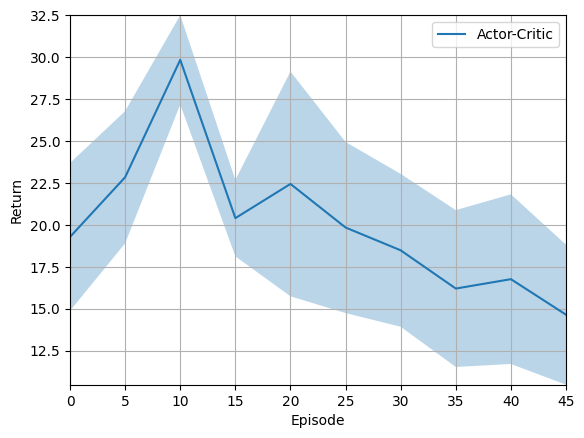

In [ ]:

ac_agents = []
for seed in SEEDS:
    ac_agent = ac_agent_constructor()
    ac_score_traces = []
    print(f"Training Actor-Critic with seed {seed}")
    for ep in tqdm(range(episodes)):
        ac_agent.train_episode(seed)
        if (ep + 1) % eval_every == 0:
            res = [rollout_score(env, ac_agent) for _ in range(eval_runs)]
            ac_score_traces.append(np.mean(res))
    ac_agents.append(ac_score_traces)

plot_results([ac_agents], ["Actor-Critic"])

Training Reinforce with seed 4


100%|██████████| 50/50 [00:09<00:00,  5.19it/s]


Training Reinforce with seed 8


100%|██████████| 50/50 [00:11<00:00,  4.36it/s]


Training Reinforce with seed 16


100%|██████████| 50/50 [00:06<00:00,  8.25it/s]


Training Reinforce with seed 23


100%|██████████| 50/50 [00:09<00:00,  5.40it/s]


Training Reinforce with seed 42


100%|██████████| 50/50 [00:08<00:00,  5.98it/s]


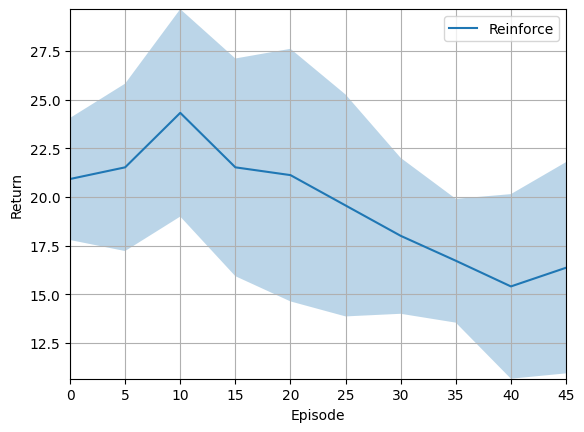

In [ ]:
ac_agents = []
for seed in SEEDS:
    ac_agent = pg_constructor()
    ac_score_traces = []
    print(f"Training Reinforce with seed {seed}")
    for ep in tqdm(range(episodes)):
        ac_agent.train_episode(seed)
        if (ep + 1) % eval_every == 0:
            res = [rollout_score(env, ac_agent) for _ in range(eval_runs)]
            ac_score_traces.append(np.mean(res))
    ac_agents.append(ac_score_traces)

plot_results([ac_agents], ["Reinforce"])


In [ ]:
ac_agents = []
for seed in SEEDS:
    ac_agent = pg_baseline_constructor()
    ac_score_traces = []
    print(f"Training Reinforce Baseline with seed {seed}")
    for ep in tqdm(range(episodes)):
        ac_agent.train_episode(seed)
        if (ep + 1) % eval_every == 0:
            res = [rollout_score(env, ac_agent) for _ in range(eval_runs)]
            ac_score_traces.append(np.mean(res))
    ac_agents.append(ac_score_traces)



Training Reinforce Baseline with seed 4


100%|██████████| 50/50 [00:18<00:00,  2.75it/s]


Training Reinforce Baseline with seed 8


100%|██████████| 50/50 [00:08<00:00,  5.77it/s]


Training Reinforce Baseline with seed 16


100%|██████████| 50/50 [00:05<00:00,  8.52it/s]


Training Reinforce Baseline with seed 23


100%|██████████| 50/50 [00:09<00:00,  5.49it/s]


Training Reinforce Baseline with seed 42


100%|██████████| 50/50 [00:08<00:00,  5.67it/s]


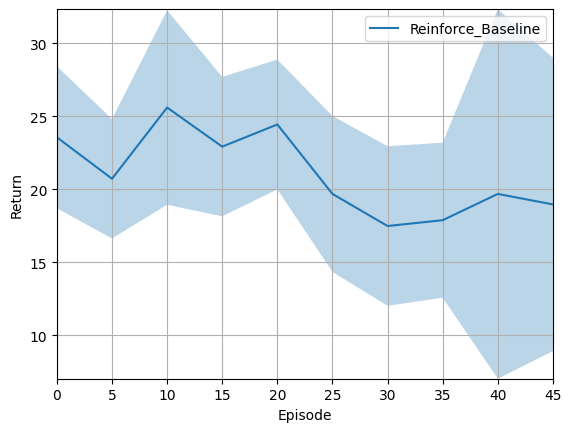

In [ ]:
plot_results([ac_agents], ["Reinforce_Baseline"])

### Visualizing AC policy (10 pts)

In [ ]:
env = gym.make("CartPole-v1", render_mode="rgb_array", max_episode_steps=200)
render_video(env, policy=ac_agents, steps=200)

In [ ]:
plt.close("all")

### Analysis (5 pts)
Based on your experiments, does actor-critic perform favorably to REINFORCE (with and/or without baseline)? Explain your observations based on the learning curves and visualization.

When the policy needs to be updated more often or in contexts with high-dimensional action spaces, Actor-Critic methods generally perform better than simple REINFORCE approaches. This is so that Actor-Critic methods can take advantage of both policy-based and value-based approaches.

Actor-Critic methods typically learn quicker than REINFORCE methods because they use value functions to predict the expected return. This enables them to bootstrap updates from the value function, perhaps leading to more efficient learning.

Stability: Actor-Critic approaches are more stable throughout training than plain REINFORCE. The use of a value function baseline minimizes the variation of gradient estimations, resulting in more consistent updates.

Sample Efficiency: Actor-Critic approaches are typically more sample-efficient than REINFORCE. This means that they require fewer samples (episodes or trajectories) to produce satisfactory results.

Final Performance: In many circumstances, Actor-Critic approaches outperform REINFORCE, particularly in complex contexts. This is because they can learn a more precise value function, which aids in better actions

variation Reduction: Actor-Critic approaches reduce policy gradient estimates' variation by removing a learned baseline (value function) from the returns. This variance reduction results in smoother learning curves and more consistent performance.

Exploration: Actor-critical approaches can balance exploration and exploitation more successfully than REINFORCE, especially when using techniques like entropy regularization or injecting noise to the policy during train.